This is probably wrong, though it seems to work. How do we make it right?

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import emcee

In [2]:
from scipy.stats import anderson_ksamp

In [122]:
nsamples = 1000

ref_sample = np.random.normal(loc=0, scale=1.0, size=nsamples)

def lnprob(p): 
    loc, scale = p
    trial_sample = np.random.normal(loc=loc, scale=scale, size=nsamples)

    ad = anderson_ksamp([ref_sample, trial_sample])
    return -ad.statistic

def lnprior(p): 
    loc, scale = p
    if -10 < loc < 10 and 0 < scale < 100:
        return 0
    return -np.inf

def lnlike(p):
    lp = lnprior(p)
    if np.isfinite(lp): 
        return lp + lnprob(p)
    
    return -np.inf

In [123]:
nwalkers, ndim = 8, 2

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=8)

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1680: UserWarning: approxi

In [124]:
n_steps = 5000

p0 = [[np.random.randn(), 0.2+np.random.rand()]
       for _ in range(nwalkers)]

p1 = sampler.run_mcmc(p0, n_steps)[0];
sampler.reset()
p2 = sampler.run_mcmc(p1, n_steps)[0];
sampler.pool.close()

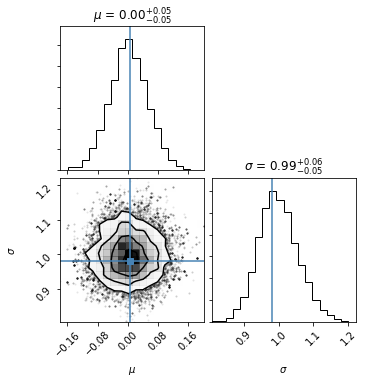

In [125]:
from corner import corner
corner(sampler.flatchain, truths=[ref_sample.mean(), ref_sample.std()], 
       labels='$\mu$,$\sigma$'.split(','), show_titles=True);